# Outlier detection techniques

In [1]:
import numpy as np
import pandas as pd 
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [2]:
ndvi_series = pd.read_csv("ndvi_time_series.csv")

ndvi_series = ndvi_series[ndvi_series["ndvi"] != -9999.000000]
ndvi_series["date"] = pd.to_datetime(ndvi_series["date"])
ndvi_series = (
    ndvi_series.drop_duplicates(subset=["date"], keep="first")
               .drop(columns=["Unnamed: 0", "id"])
)

ndvi_series.head()

,date,ndvi
0,2020-01-02,0.497022
1,2020-01-07,0.158185
2,2020-01-12,0.154410
3,2020-01-17,0.159150
4,2020-01-22,0.118168


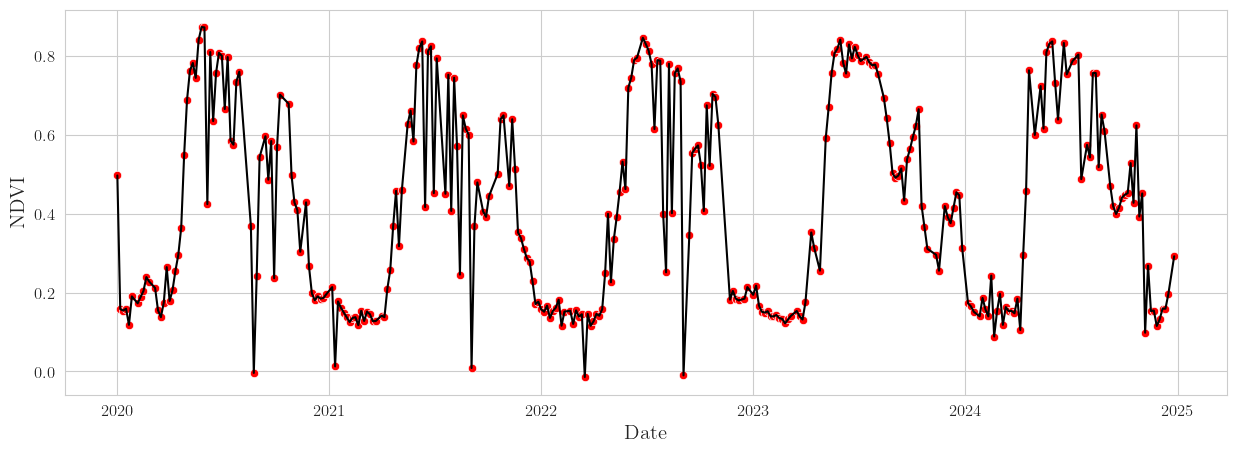

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(ndvi_series, x="date", y="ndvi", color="red", ax=ax)
sns.lineplot(ndvi_series, x="date", y="ndvi", color="black", ax=ax)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("NDVI", fontsize=15)

plt.show()

## Applying Isolation Forest algorithm

In [81]:
def find_outliers(col: pd.Series) -> np.ndarray:
    """ 
    This function applies the Isolation Forest algorith on the
    time-series data for detecting possible outliers.

    The value for contamination must account for the natural variation
    in the data. We choose 0.025.
    """

    X = col.values.reshape(-1, 1) # Format input into required shape
    model = IsolationForest(
        n_estimators=150,
        contamination=0.025,
        random_state=15
    ) # Setting contamination to 0.1
    model.fit(X)

    # Predictions will consist of two values: +1 for inliers and -1 for outliers
    Y_preds = model.predict(X)

    return Y_preds

ndvi_series_new = ndvi_series.assign(outlier = find_outliers(ndvi_series["ndvi"]))

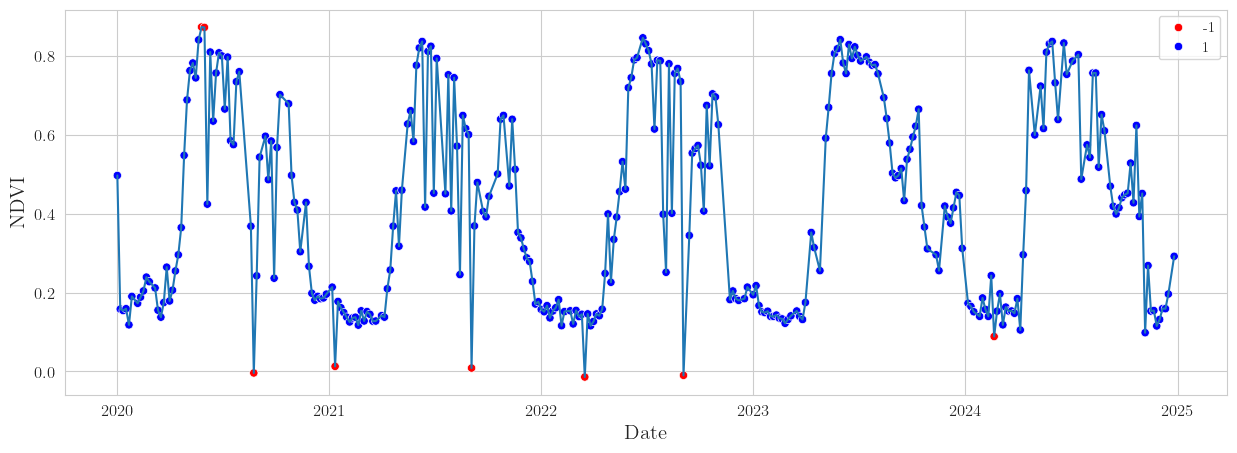

In [82]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(ndvi_series_new, x="date", y="ndvi", hue="anomaly", palette=["red", "blue"], ax=ax)
sns.lineplot(ndvi_series_new, x="date", y="ndvi", ax=ax)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("NDVI", fontsize=15)

plt.show()

In [6]:
def clean_ndvi_series(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["system:index", ".geo"]) # Remove useless columns

    uuid_col = df.columns[-1]
    new_cols = [uuid_col] + list(df.columns[:-1])
    df = df.reindex(columns=new_cols)

    df.iloc[:, 1:] = df.iloc[:, 1:].fillna(method="bfill", axis=1)

    df_melted = (
        df.melt(id_vars="uuid", var_name="date", value_name="ndvi")
          .groupby("uuid", group_keys=False).apply(lambda row: row.sort_values(by="date", ascending=False))
    )
    df_melted["date"] = pd.to_datetime(df_melted["date"])
    df_melted = df_melted.drop_duplicates(subset=["uuid", "date"], keep="first")

    return df_melted.reset_index(drop=True)

In [7]:
ndvi_series_tile_0 = pd.read_csv("Trans_Nzoia_1_tile_0_NDVI.csv")

ndvi_series_tile_0 = clean_ndvi_series(ndvi_series_tile_0)

/var/folders/tn/5r78nf7j5lq1jcy9q50tq8dw0000gn/T/ipykernel_56436/3512743090.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].fillna(method="bfill", axis=1)
/var/folders/tn/5r78nf7j5lq1jcy9q50tq8dw0000gn/T/ipykernel_56436/3512743090.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby("uuid", group_keys=False).apply(lambda row: row.sort_values(by="date", ascending=False))


In [83]:
import time 

ti = time.perf_counter()
def f():
    #uuid_list = ndvi_series_tile_0["uuid"].unique().tolist()

    df = ndvi_series_tile_0.copy()

    #df["outlier"] = np.nan 
    df["outlier"] = df.groupby("uuid")["ndvi"].transform(find_outliers)
    return df

df = f()
tf = time.perf_counter()

print(tf-ti)

135.78173004199925


In [84]:
df_clean = df.copy()
df_clean.loc[df_clean["outlier"]==-1, "ndvi"] = np.nan 

df_clean = df_clean.fillna(method="bfill")

/var/folders/tn/5r78nf7j5lq1jcy9q50tq8dw0000gn/T/ipykernel_56436/2161317008.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method="bfill")


In [88]:
import ipywidgets as widgets
#from ipywidgets import interact, interact_manual
from IPython.display import display

def plot_timeseries(uuid: str) -> None:
    df_subset_1 = df[
        df["uuid"] == uuid
    ]

    df_subset_2 = df_clean[
        df_clean["uuid"] == uuid
    ]

    fig, ax = plt.subplots(2, 1, figsize=(15, 10))

    sns.scatterplot(df_subset_1, x="date", y="ndvi", hue="outlier", palette=["red", "blue"], ax=ax[0])
    sns.lineplot(df_subset_1, x="date", y="ndvi", alpha=0.5, ax=ax[0])
    ax[0].set_xlabel("Date", fontsize=15)
    ax[0].set_ylabel("Mean NDVI", fontsize=15)
    ax[0].set_ylim(-0.1, 1.1)

    sns.scatterplot(df_subset_2, x="date", y="ndvi", ax=ax[1])
    sns.lineplot(df_subset_2, x="date", y="ndvi", alpha=0.5, ax=ax[1])
    ax[1].set_xlabel("Date", fontsize=15)
    ax[1].set_ylabel("Mean NDVI", fontsize=15)
    ax[1].set_ylim(-0.1, 1.1)

    plt.show()

uuid_list = ndvi_series_tile_0["uuid"].unique().tolist()
uuid_dropdown = widgets.Dropdown(
    options=uuid_list
)
ui = widgets.HBox([uuid_dropdown])

output = widgets.interactive_output(
    plot_timeseries, {'uuid': uuid_dropdown}
)
display(ui, output)

Output()